In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.express as px
import spacy
import emoji
import nltk
import gensim
import torch
import torch.nn as nn
#nltk.download('stopwords')
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize , RegexpTokenizer
from nltk.stem import SnowballStemmer
import qalsadi.lemmatizer
from fuzzywuzzy import fuzz,process
import tensorflow as tf
import tensorflow_hub as hub
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split,cross_val_score
from tensorflow.keras import models, layers, regularizers, optimizers
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC,LinearSVC
#from transformers import BertModel, BertTokenizer
from collections import defaultdict
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

In [10]:
from transformers import DistilBertTokenizer, DistilBertModel,AutoTokenizer, AutoModelForSequenceClassification
from transformers import pipeline

C:\Users\BIGNETWORK\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [350]:
df0=pd.read_excel("C:/Users/BIGNETWORK/Desktop/PFE/dataset/project/git-one/datasets/resaux_comments.xlsx")
df1=pd.read_excel("C:/Users/BIGNETWORK/Desktop/PFE/dataset/project/git-one/datasets/fb_comments.xlsx")
df2=pd.read_excel("C:/Users/BIGNETWORK/Desktop/PFE/dataset/project/git-one/datasets/hainer_ranim.xlsx")
df3=pd.read_excel("C:/Users/BIGNETWORK/Desktop/PFE/dataset/project/git-one/datasets/newest.xlsx")
df4=pd.read_excel("C:/Users/BIGNETWORK/Desktop/PFE/dataset/project/git-one/datasets/hateonly_mehdi.xlsx")

In [83]:
df6=pd.read_excel("C:/Users/BIGNETWORK/Desktop/PFE/dataset/project/git-one/datasets/web.xlsx")

In [351]:
df = pd.concat([df0, df1, df2, df3,df4], axis=0, ignore_index=True)

In [430]:
dff = pd.concat([df0, df1, df2, df3,df4], axis=0, ignore_index=True)

In [ ]:
df = df.sample(frac=1).reset_index(drop=True)
df

In [89]:
#df.to_excel("C:/Users/BIGNETWORK/Desktop/PFE/dataset/datasetgoogle_arab.xlsx")
#df_fr.to_excel("C:/Users/BIGNETWORK/Desktop/PFE/dataset/datasetgoogle_fr.xlsx")
#df_en.to_excel("C:/Users/BIGNETWORK/Desktop/PFE/dataset/datasetgoogle_en.xlsx")

In [439]:
df=df.dropna(subset = ['comments'])

In [424]:
df['comments'].isna().sum()

0

In [94]:
df['class'].value_counts()

 0    9461
 1    3101
-1    3065
Name: class, dtype: int64

*** 
---
___

## <span style='font-family:Georgia'> Preprocessing of Text.

### <span style='font-family:serif'> Function to Remove Emojis

In [3]:
def strip_emoji(text):
    return emoji.replace_emoji(text,replace="")

### <span style='font-family:serif'> Removing stop words

In [4]:
# Load stopwords for each language
with open('Algerian-Arabic-stop-words.txt', 'r', encoding='utf-8') as f:
    stop_words_ar_dz = set([line.strip() for line in f])
stop_words_en = set(stopwords.words('english'))
stop_words_fr = set(stopwords.words('french'))
# Create a custom tokenizer for Arabic words
tokenizer = RegexpTokenizer('\w+|\$[\d\.]+|\S+')
# Define a function to remove stop words from a text
def remove_stopwords(text):
    words = tokenizer.tokenize(text)
    words_filtered = []
    for word in words:
        if word not in stop_words_ar_dz and word not in stop_words_en and word not in stop_words_fr:
            words_filtered.append(word)
    return ' '.join(words_filtered)


### <span style='font-family:serif'> Fucntion to remove special characters, URLs, duplicated letters, punctuations

In [5]:
# Define a function to perform the text cleaning operations
def clean_text(text):
    text = text.replace("_", " ").replace("⁰", "")
    text = re.sub(r'[\r\n]+', ' ', text).lower()  
    text = re.sub(r"(?:\@|https?\://)\S+", "", text) #URLs
    #text = re.sub(r'@\w+', '', text)
    text = re.sub(r'[^\w\s]', ' ', text)  # Remove punctuation marks 
    text = re.sub(r'\b\d+\b', '', text) # Remove only standalone numbers
    text = re.sub(r'[@#&$]\w+', '', text)  # Remove special characters
    text = re.sub(r'(\w)\1+', r'\1', text) # remove duplicated letters
    return text

In [689]:
print(clean_text('https://chat.openai.com/c/6db5d454-e400-4faa-ab02-356b96ce62be èāêôãûÎŠlâɱíóøçïčý موبليس هي لعرا فيهم كاامل 00⁰000000000000'))

 èāêôãûîšlâɱíóøçïčý موبليس هي لعرا فيهم كامل 


### <span style='font-family:serif'> Function to remove mutiple sequence spaces

In [6]:
def remove_mult_spaces(text):
    return re.sub("\s\s+" , " ", text)

### <span style='font-family:serif'> Function to replace abreviation with the original word

In [7]:
with open('regroupement.txt', 'r',encoding='utf-8') as f:
    lines = f.readlines()
    dictionary = {}
    for line in lines:
        key, values = line.split(':')
        values = values.strip().split(',')
        for value in values:
            dictionary[value.strip()] = key.strip()


In [8]:
def abreviation(text):
    words = text.split()
    new_words = [dictionary.get(word, word) for word in words]
    return ' '.join(new_words)


In [367]:
print(abreviation('conix rahi bezaf takila'))

connexion rahi bezaf t9ila


### <span style='font-family:serif'> Function for language detection

- downloading and saving the model papluca/xlm-roberta-base-language-detection from huggung face

In [18]:
#model_name = "papluca/xlm-roberta-base-language-detection"
#model = AutoModelForSequenceClassification.from_pretrained(model_name)
#tokenizer = AutoTokenizer.from_pretrained(model_name)
#Save the model and tokenizer to a directory
#model.save_pretrained('saved_model_langdetec')
#tokenizer.save_pretrained('saved_model_langdetec')

C:\Users\BIGNETWORK\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\huggingface_hub\file_download.py:133: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\BIGNETWORK\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


In [11]:
#load the model and tokenizer 
model_lang = AutoModelForSequenceClassification.from_pretrained('saved_model_langdetec')
tokenizer_lang = AutoTokenizer.from_pretrained('saved_model_langdetec')

In [12]:
classifier = pipeline("text-classification", model=model_lang, tokenizer=tokenizer_lang)

def lang_det(texte):
    texte=texte[:514]
    result = classifier(texte)
    
    if result[0]["score"] >= 0.2:
        langage = result[0]["label"]
    else:
        langage = 'dz'
    if langage not in ['en','fr']:
        langage = 'dz'
    
    
    return langage

In [684]:
print(lang_det('suivant'))

fr


### <span style='font-family:serif'> Fonction that translate from Arabizi to Algerian Arabic alphabet using mapping dictionary

In [13]:
# Define the mapping dictionary
mapping = {
    'ai':'ي','ae':'ع','au': 'و','tion':'صيو', 'gh':'غ', 'kh':'خ','sh':'ش','dj':'ج','zz': 'ز','dh':'ض',
    'ch':'ش','ga': 'ڨ','go': 'ڨ','g': 'ج', 'h': 'ه', 'i': 'ي', 'j': 'ج', 'k': 'ك', 'l': 'ل','e': '', 'f': 'ف',
    'm': 'م', 'n': 'ن', 'ou': 'و','a': '','c':'ك', 'o': '', 'p': 'ب', 'q': 'ك', 'r': 'ر','d': 'د',
    's': 'س', 't': 'ت', 'u': 'ي', 'v': 'ف', 'w': 'و', 'x': 'كس','b': 'ب','6':'ط','2':'ا','8':'',
    'y': 'ي', 'z': 'ز','9':'ق','7':'ح','é':'','3':'ع','5':'خ','0':'','1':'','4':'',
}
# Define the translation function
def arabizi_to_arabic(text):

    pattern = '[ĩèāêôãûÎŠâɱíóøçïčýù]'
    
    text = re.sub(pattern, '', text)
    # Replace each Arabizi letter with its corresponding Arabic alphabet dialect letter
    for letter, value in mapping.items():
        
        text = re.sub(letter, value, text)
    return text


# Example usage
arabizi_text = "alah yal3ankom"
arabic_text = arabizi_to_arabic(arabizi_text)
print(arabic_text)

له يلعنكم


### <span style='font-family:serif'> Function to  apply stemming to words

In [14]:
def stem_words(text , language):
    stemmer = None
    words = tokenizer.tokenize(text)
    if language == 'dz':
        text=arabizi_to_arabic(text)
        stemmed_text = text
    elif language == 'fr':
        stemmer = SnowballStemmer('french')
        stemmed_words = [stemmer.stem(word) for word in words]
        stemmed_text = ' '.join(stemmed_words)
    elif language == 'en':
        stemmer = SnowballStemmer('english')
        stemmed_words = [stemmer.stem(word) for word in words]
        stemmed_text = ' '.join(stemmed_words)
    else:
        return text # No stemmer available for this language
    
    return stemmed_text

In [154]:
print(stem_words('eating banan hello',"en"))

eat banan hello


### <span style='font-family:serif'> Function to apply lemmatization to words

In [18]:
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\BIGNETWORK\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\BIGNETWORK\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [15]:

nlp_en = spacy.load('en_core_web_sm')
nlp_fr = spacy.load('fr_core_news_sm')
def lemmatize(text , lang):
    # Tokenize the text
    words = tokenizer.tokenize(text)

    # Define lemmatizer for each language
    lemma_dz = qalsadi.lemmatizer.Lemmatizer()
    # Lemmatize each word in the text
    lemmatized_words = []
    if lang =='en':
        doc = nlp_en(text)
        for token in doc:
            lemma = token.lemma_
            lemmatized_words.append(lemma)
    elif lang =='fr':
        doc = nlp_fr(text)
        for token in doc:
            lemma = token.lemma_
            lemmatized_words.append(lemma)
    elif lang =='dz':
        for word in words:
            lemma = lemma_dz.lemmatize(word)
            lemmatized_words.append(lemma)
    
    # Join the lemmatized words to form the lemmatized text
    lemmatized_text = ' '.join(lemmatized_words)
    
    return lemmatized_text

In [156]:
print(lemmatize('hello averyone how are doing today',"en"))

hello averyone how be do today


### <span style='font-family:serif'> Function to Preprocess the text by applying all above functions

In [16]:
def preprocess1(text):
    text = strip_emoji(text)
    text = clean_text(text)
    text = remove_mult_spaces(text)
    text = abreviation(text)
    return text


In [17]:
def preprocess2(text):
    langue = lang_det(text)
    text = stem_words(text , langue)
    text = remove_stopwords(text)
    text = lemmatize(text , langue)
    return text

In [833]:
if df['comments'].dtype == 'object':
    df['comments_clean'] = df['comments'].apply(preprocess1)

In [85]:
if df6['comments'].dtype == 'object':
    df6['comments_clean'] = df6['comments'].apply(preprocess1)

In [406]:
df['comments_clean'].replace('', np.nan, inplace=True)
missing_values = df[df['comments_clean'].isnull()]
#df=df.dropna(subset = ['comments_clean'])
len(missing_values)

0

In [383]:
df=df.dropna(subset = ['comments_clean'])

### <span style='font-family:serif'> Regroupement et traitement de fautes d’orthographe

### <span style='font-family:serif'> Function to return the soundex code

In [21]:
# function to get soundex code for a given word
def get_soundex(word):
    soundex_map = {
        'BFPV': '1',
        'CGJKQSXZ': '2',
        'DT': '3',
        'L': '4',
        'MN': '5',
        'R': '6',
        'AEIOUHWY': '0'
    }
    # Step 1: Keep the first letter of the word
    code = word[0].upper()
    
    # Step 2: Replace all remaining letters based on the soundex mapping
    for char in word[1:].upper():
        for key, value in soundex_map.items():
            if char in key:
                code += value
                break
    
    # Step 3: Remove consecutive duplicates except for the first letter
    code = code[0] + ''.join(char for i, char in enumerate(code[1:], start=1) if char != code[i-1] and char != '0')
    
    # Step 4: Pad or truncate to a length of 4 characters
    code = code + '000'
    return code[:4]

In [86]:
# set threshold for similarity score
threshold = 70

# create dictionary to hold fuzzywuzzy scores and their associated words
fuzzy_dict = defaultdict(list)

# create dictionary to hold soundex codes and their associated words
code_dict = defaultdict(list)

# create a list containing all the words in the comments
words_list = [word for comment in df6['comments_clean'] for word in tokenizer.tokenize(comment) if not any('\u0600' <= c <= '\u06FF' for c in word)]

# iterate over all words in the comments
for word in words_list:
    # calculate soundex code for the word
    code = get_soundex(word)
    # add word to the dictionary
    code_dict[code].append(word)

# iterate over all words in code_dict
for code, words in code_dict.items():
    # calculate fuzzywuzzy score for each pair of words
    for i in range(len(words)):
        for j in range(i+1, len(words)):
            score = fuzz.token_sort_ratio(words[i], words[j])
            # if the similarity score is above the threshold, update the fuzzy dictionary
            if score >= threshold:
                fuzzy_dict[words[i]].append((score, words[j]))

# create dictionary to hold word replacements and their associated fuzzywuzzy scores
replace_dict = {}

# iterate over all soundex codes and associated words to find word replacement wich is the one having the maximum score in the cod_dict
for code, words in code_dict.items():
    # skip codes with only one word
    if len(words) == 1:
        continue
    # compare all pairs of words with the same code
    for i in range(len(words)):
        max_score = 0
        max_match = None
        for j in range(i+1, len(words)):
            score = fuzz.token_sort_ratio(words[i], words[j])
            # if the similarity score is above the threshold, update the replacement dictionary
            if score >= threshold:
                if score > max_score:
                    max_score = score
                    max_match = words[j]
        if max_match is not None:
            replace_dict[words[i]] = max_match

# iterate over all comments and replace words with their soundex group words
for i in range(len(df6)):
    try:
        words =tokenizer.tokenize(df6.loc[i,'comments_clean'])
        for j in range(len(words)):
            # check if word is in Arabic script or not
            if any('\u0600' <= c <= '\u06FF' for c in words[j]):
                continue  # skip Arabic words
            # calculate soundex code for the word
            code = get_soundex(words[j])
            # check if the code has associated words
            if code in code_dict:
                # check if the word has a replacement
                if words[j] in replace_dict:
                    words[j] = replace_dict[words[j]]
                else:
                    # check if any of the associated words have a replacement
                    max_score = 0
                    max_match = None
                    for score, match in fuzzy_dict[words[j]]:
                        if match in replace_dict:
                            score = fuzz.token_sort_ratio(words[j], replace_dict[match])
                            if score > max_score:
                                max_score = score
                                max_match = replace_dict[match]
                    if max_match is not None:
                        words[j] = max_match
    except:
        continue
    # join the words back into a string and replace the comment in the dataframe
    df6.loc[i, 'comments_corr'] = ' '.join(words)
#check if 'comments_corr' is NaN and set it to original value
df6['comments_corr'].fillna(df6['comments_clean'], inplace=True)



In [418]:
df[df['class']==0].sample(10)

,comments,class,comments_clean,comments_corr
14252,Chkalha,0.0,chkalha,chakla
1353,Avez-vous des abonnements moins de 1000 DA par...,0.0,avez vous des abonements moins de da par mois,avec vous des abonement moins de da par mois
9735,Mayji ykmel ramdan mniche aref ge3 chaydir,0.0,mayji ykmel ramdan mniche aref ge3 chaydir,mayji ykmel ramdan manich aref ge chaydir
16272,9iw,0.0,9iw,9iw
11659,شغلوا : لاااي لااي لاي لاااي,0.0,شغلوا لاي لاي لاي لاي,شغلوا لاي لاي لاي لاي
13475,Tsma fiha toghyan😂,0.0,tsma fiha toghyan,tsama fiha toghyan
3581,انترنت نتاعكم راها بالبايت ميش لاحقا حتى للكيل...,0.0,انترنت نتاعكم راها بالبايت ميش لاحقا حتى لكيلو...,انترنت نتاعكم راها بالبايت ميش لاحقا حتى لكيلو...
4797,يا جازي اعطوني حقي كل شهر نفليكسي 1500 دج وهيا...,0.0,يا جازي اعطوني حقي كل شهر نفليكسي دج وهيا ثقيل...,يا جازي اعطوني حقي كل شهر نفليكسي دج وهيا ثقيل...
335,مصر وكاميرون وعيسى حياتو قصدك,0.0,مصر وكاميرون وعيسى حياتو قصدك,مصر وكاميرون وعيسى حياتو قصدك
14877,Ooredoo Switch ماتوصلوهاش,0.0,oredo switch ماتوصلوهاش,oredo switch ماتوصلوهاش


In [419]:
if df['comments'].dtype == 'object':
    df['comments_clean'] = df['comments_corr'].apply(preprocess2)

In [87]:
if df6['comments'].dtype == 'object':
    df6['comments_clean'] = df6['comments_corr'].apply(preprocess2)

In [420]:
df.sample(20)

,comments,class,comments_clean,comments_corr
6202,ليست نهايت العالم.,0.0,نهايت عالم,ليست نهايت العالم
18409,conx Tnak,-1.0,connexion tnak,connexion tnak
10612,واقيلا من ضعف الانترنت تاعكم هدا وين لحق الاعت...,0.0,واقيلا ضعف الانترنت تاع هد حق اعتذار تاع,واقيلا من ضعف الانترنت تاعكم هدا وين لحق الاعت...
7137,هو عفيفي الي ماسك البيدج ولا ايه,0.0,عفيف ماس البيدج ايه,هو عفيفي الي ماسك البيدج ولا ايه
13915,تقدر دير خير من هك يا خويا مراد بالاشهار هاذا ...,0.0,تقدر دير خير هك خوى مراد بالاشهار هاذا حاب تقو...,تقدر دير khir من هك يا خويا مراد بالاشهار هاذا...
1730,عجبني,0.0,عجب,عجبني
536,هذا واش تعرفو الريزو ماتعرفوش تخدموه اخدمولنا ...,0.0,تعرف الريزو ماتعرفوش خدم اخدمولنا الريزو,هذا واش تعرفو الريزو ماتعرفوش تخدموه اخدمولنا ...
14612,كاش عرض خاص للأنترنت فقط في جيزي بدون رصيد,0.0,عرض خاص لأنترنت فقط جيزة بدون رصيد,كاش عرض خاص لأنترنت فقط في جيزي بدون رصيد
18506,هذا أنت,0.0,,هذا أنت
10256,l zad nik ta3kom conx li Zebiiiii,-1.0,زاد ناك تاع كننكسين زبى,l zad nik ta3kom connexion li zebi


### <span style='font-family:serif'> Dealing with Duplicates

In [445]:
df["comments_clean"].duplicated().sum()

0

In [446]:
df= df.drop_duplicates(subset=["comments_clean"], keep="first")

#### <span style='font-family:serif'>Duplicates removed

### <span style='font-family:serif'> Tokenization

In [24]:
tokenizer = RegexpTokenizer(r'\w+')
def tokenization(text):
    words=tokenizer.tokenize(text)
    return words

In [88]:
df6['comments_clean']=df6['comments_clean'].apply(str)
if df6['comments_clean'].dtype == 'object':
    df6['comments_list'] = df6['comments_clean'].apply(tokenization)


In [26]:
#df=pd.read_excel("C:/Users/BIGNETWORK/Desktop/PFE/dataset/datasetgoogle.xlsx")

### <span style='font-family:serif'> Checking length of various tweet texts


In [449]:
text_len = []
for text in df.comments_list:
    comment_len = len(text)
    text_len.append(comment_len)
df['text_len'] = text_len

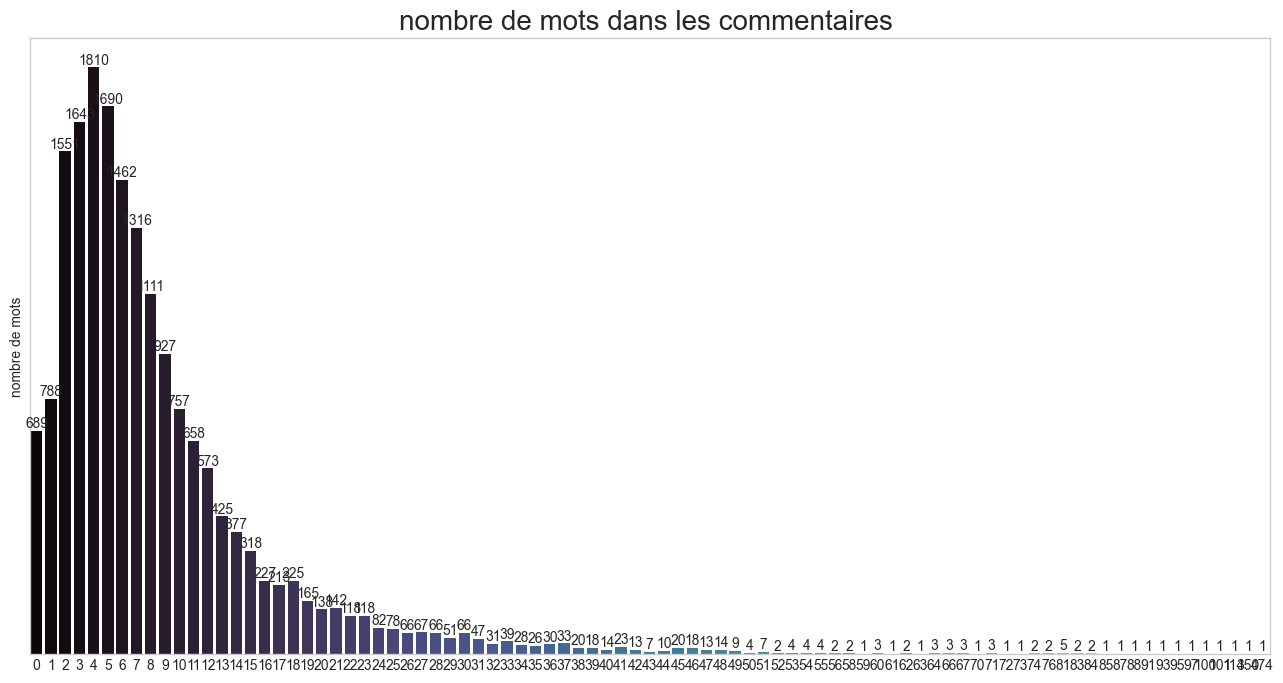

In [455]:
plt.figure(figsize=(16,8))
ax = sns.countplot(x='text_len', data=dff, palette='mako')
plt.title('nombre de mots dans les commentaires ', fontsize=20)
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('nombre de mots')
plt.xlabel('')
plt.show()


### <span style='font-family:serif'>Removing text without words

In [ ]:
df = df[df['text_len']!=0]

In [26]:
from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image
import arabic_reshaper
from bidi.algorithm import get_display

In [497]:
def plot_wordcloud(class_type):
    string = ""
    for i in df[df['class'] == class_type].comments_clean.values:
        string = string + " " + i.strip()
    font_path = 'C:/Users/BIGNETWORK/Desktop/PFE/dataset/project/Janna LT Bold/Janna LT Bold.ttf'
    # Reshape Arabic text for proper rendering
    reshaped_text = arabic_reshaper.reshape(string)
    reshaped_text = get_display(reshaped_text)
    custom_mask = np.array(Image.open('C:/Users/BIGNETWORK/Desktop/PFE/dataset/project/logo_djezzy_play.png'))
    mask_colors = ImageColorGenerator(custom_mask)
    wordcloud = WordCloud(background_color='white',max_words=1600, max_font_size=100,
                          random_state=42, width=custom_mask.shape[1], height=custom_mask.shape[0],
                          mask=custom_mask, min_font_size=10, color_func=mask_colors,font_path=font_path).generate(reshaped_text)

    plt.figure(figsize=(7, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.tight_layout()
    plt.title('Word Cloud')
    plt.show()

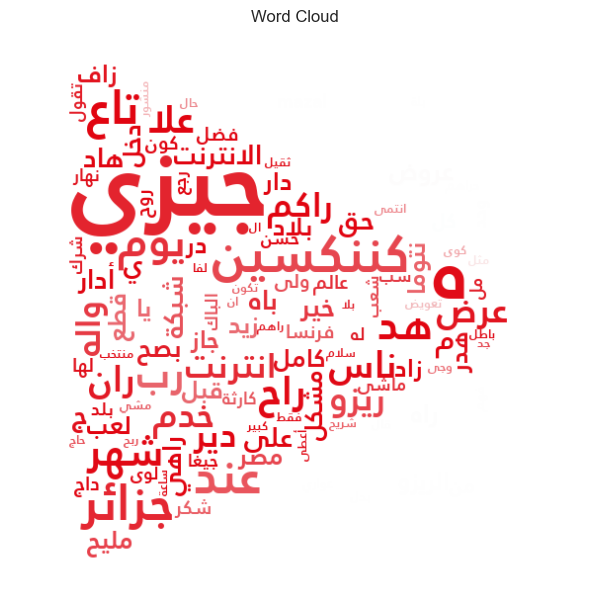

In [498]:
plot_wordcloud(0)

### <span style='font-family:serif'>Exploratory Data Analysis

C:\Users\BIGNETWORK\AppData\Local\Temp\ipykernel_8376\3761965591.py:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


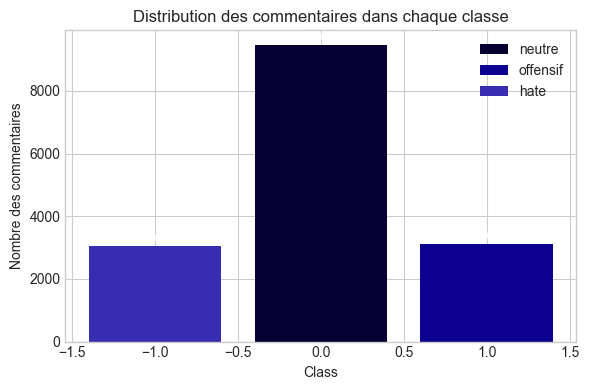

In [95]:

# Count the number of comments in each class
class_counts = df['class'].value_counts()

# Set the figure size and background color
plt.figure(figsize=(6, 4))
plt.style.use('seaborn-whitegrid')
colors = ['#040032', '#0C0091', '#382DB1']

# Create the bar plot
bars = plt.bar(class_counts.index, class_counts.values, color=colors)

# Add labels and title
plt.xlabel('Class')
plt.ylabel('Nombre des commentaires')
plt.title('Distribution des commentaires dans chaque classe')

# Add value labels to the bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, height,
             ha='center', va='bottom', color='white', fontweight='bold')

# Add legend for each class
legend_labels = ['neutre', 'offensif', 'hate']
plt.legend(bars, legend_labels)

# Show the plot
plt.tight_layout()
plt.show()


In [431]:
df['comments_lang'] = df['comments'].apply(lang_det)

In [521]:
df['comments_lang'].value_counts()

dz    15398
fr      656
en      163
Name: comments_lang, dtype: int64

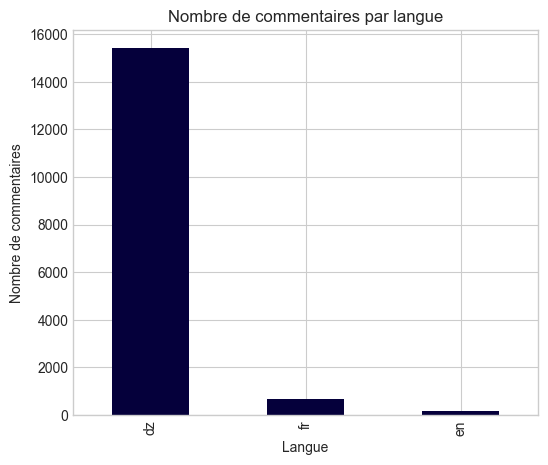

In [461]:
# Compter le nombre de commentaires par langue
langue_counts = df['comments_lang'].value_counts()

# Créer le graphique
plt.figure(figsize=(6, 5))
langue_counts.plot(kind='bar', color='#05003B')

# Définir les étiquettes des axes et du titre
plt.xlabel('Langue')
plt.ylabel('Nombre de commentaires')
plt.title('Nombre de commentaires par langue')

# Afficher le graphique
plt.show()

### <span style='font-family:serif'> Split train dataset into train, validation and test sets

In [ ]:
df_fr = pd.DataFrame(columns=df.columns)
df_en = pd.DataFrame(columns=df.columns)
for index, row in df.iterrows():
    try:
        language = row['comments_lang']
        if language == 'fr':
            df_fr = df_fr.append(row)
            df.drop(index, inplace=True)
        elif language == 'en':
            df_en = df_en.append(row)
            df.drop(index, inplace=True)
    except:
        # Language detection failed, you can handle or skip such cases based on your needs
        pass

In [90]:
df=pd.read_excel("C:/Users/BIGNETWORK/Desktop/PFE/dataset/datasetgoogle_arab.xlsx")

In [96]:
X,Y = df['comments_clean'],df['class']

In [ ]:
sentence_vectors = model_ar.encode_sentences(X,combine_strategy="mean")

In [ ]:
Y = np.where(Y==-1, 2, Y)

In [ ]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from collections import Counter

# Apply RandomOverSampler with a specified sampling strategy for each class
over = RandomOverSampler(sampling_strategy={0: 9455, 1: 5000, 2: 5000})
X_over, Y_over = over.fit_resample(sentence_vectors, Y)

# Apply RandomUnderSampler to balance the dataset
under = RandomUnderSampler(random_state=42)
X_balanced, Y_balanced = under.fit_resample(X_over, Y_over)

print(Counter(Y_balanced))

In [111]:
# Split the data into train, test, and validation sets
X_train, X_test, y_train, y_test = train_test_split(X_balanced, Y_balanced, test_size=0.15, stratify=Y_balanced, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, stratify=y_train, random_state=42)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape, X_val.shape)

(11289,) (11289,) (2345,) (2345,) (1993,) (1993,)


### <span style='font-family:serif'>downlaod the model bert for word representation

In [ ]:
from simpletransformers.language_representation import RepresentationModel
model = RepresentationModel(
        model_type="bert",
        model_name="bert-base-uncased",
        use_cuda=False
    )

In [39]:
model_ar = RepresentationModel(
    model_type="bert",
    model_name="bert-base-multilingual-cased",
    use_cuda=False
)

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTextRepresentation: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTextRepresentation from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTextRepresentation from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [222]:
from sklearn.metrics import precision_score, recall_score, f1_score
def precision(y_true, y_pred):
    y_pred = tf.argmax(y_pred, axis=1)
    return tf.py_function(lambda y_true, y_pred: precision_score(y_true, y_pred, average='weighted', zero_division=1), (y_true, y_pred), tf.float32)

def recall(y_true, y_pred):
    y_pred = tf.argmax(y_pred, axis=1)
    return tf.py_function(lambda y_true, y_pred: recall_score(y_true, y_pred, average='weighted', zero_division=1), (y_true, y_pred), tf.float32)

def f1(y_true, y_pred):
    y_pred = tf.argmax(y_pred, axis=1)
    return tf.py_function(lambda y_true, y_pred: f1_score(y_true, y_pred, average='weighted', zero_division=1), (y_true, y_pred), tf.float32)

* GRU

In [821]:
# Reshape the input data
X_train_balanced_reshaped = X_train_balanced.reshape(X_train_balanced.shape[0], 1, X_train_balanced.shape[1])
V_val_reshaped = sentence_vectors_val.reshape(sentence_vectors_val.shape[0], 1, sentence_vectors_val.shape[1])
# Define the model architecture
model_gru = models.Sequential()
model_gru.add(layers.GRU(264, input_shape=(X_train_balanced_reshaped.shape[1], X_train_balanced_reshaped.shape[2]), return_sequences=True))
model_gru.add(layers.GRU(132, return_sequences=True))
model_gru.add(layers.GRU(32))
model_gru.add(layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.002)))
model_gru.add(layers.Dropout(0.2))
model_gru.add(layers.Dense(3, activation='softmax'))

# Compile the model
optim = optimizers.Adam(learning_rate=1e-5)
model_gru.compile(optimizer=optim, loss='sparse_categorical_crossentropy', metrics=['accuracy', precision ,recall, f1])

# Train the model
class_weights = {0: 1.5, 1: 2.0, 2: 1.5}  
history = model_gru.fit(X_train_balanced_reshaped, y_train_balanced,validation_data=(V_val_reshaped, y_val), epochs=30, batch_size=16, class_weight=class_weights)

# Evaluate the model
test_loss, test_acc,prec,recall,f1 = model_gru.evaluate(sentence_vectors_test.reshape(sentence_vectors_test.shape[0], 1, sentence_vectors_test.shape[1]), y_test)
print('Test accuracy:', test_acc)
print('Test precision:', prec)
print('Test recall:', recall)
print('Test f1-score:', f1)

Epoch 1/30
1282/1282 [==============================] - 38s 22ms/step - loss: 1.8458 - accuracy: 0.3928 - precision: 0.7344 - recall: 0.3928 - f1: 0.2845 - val_loss: 1.1526 - val_accuracy: 0.2606 - val_precision: 0.7811 - val_recall: 0.2606 - val_f1: 0.1762
Epoch 2/30
1282/1282 [==============================] - 28s 22ms/step - loss: 1.6830 - accuracy: 0.5090 - precision: 0.6774 - recall: 0.5090 - f1: 0.4582 - val_loss: 1.0610 - val_accuracy: 0.3966 - val_precision: 0.6998 - val_recall: 0.3966 - val_f1: 0.4012
Epoch 3/30
1282/1282 [==============================] - 27s 21ms/step - loss: 1.5757 - accuracy: 0.5649 - precision: 0.6569 - recall: 0.5649 - f1: 0.5491 - val_loss: 1.0293 - val_accuracy: 0.4638 - val_precision: 0.7001 - val_recall: 0.4638 - val_f1: 0.4891
Epoch 4/30
1282/1282 [==============================] - 27s 21ms/step - loss: 1.5101 - accuracy: 0.5988 - precision: 0.6701 - recall: 0.5988 - f1: 0.5925 - val_loss: 0.9979 - val_accuracy: 0.5091 - val_precision: 0.7063 - val_

In [822]:
y_pred = model_gru.predict(sentence_vectors_test.reshape(sentence_vectors_test.shape[0], 1, sentence_vectors_test.shape[1]))
y_pred_labels = np.argmax(y_pred, axis=1)
cm = confusion_matrix(y_test, y_pred_labels)
print(cm)

71/71 [==============================] - 4s 5ms/step
[[792 500 127]
 [100 242  45]
 [ 34 110 307]]


* CNN

In [284]:
X_train_balanced_reshaped.shape

(23238, 1, 768)

In [ ]:
# Define the model architecture
model_cnn = models.Sequential()
model_cnn.add(layers.Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train_balanced_reshaped.shape[0], X_train_balanced_reshaped.shape[2])))
model_cnn.add(layers.MaxPooling1D(pool_size=2))
model_cnn.add(layers.Conv1D(32, kernel_size=3, activation='relu'))
model_cnn.add(layers.MaxPooling1D(pool_size=2))
model_cnn.add(layers.Flatten())
model_cnn.add(layers.Dense(3, activation='softmax'))

# Compile the model
model_cnn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model_cnn.fit(X_train_balanced_reshaped.reshape(X_train_balanced_reshaped.shape[0], X_train_balanced_reshaped.shape[2]), y_train_balanced, epochs=10, batch_size=32)
# Evaluate the model
test_loss, test_acc = model_cnn.evaluate(sentence_vectors_test.reshape(sentence_vectors_test.shape[0], 1, sentence_vectors_test.shape[1]), y_test)
print('Test accuracy:', test_acc)

* CNN + GRU

In [ ]:
# Reshape the input data
X_train_balanced_reshaped = X_train_balanced.reshape(X_train_balanced.shape[0], X_train_balanced.shape[1],1)
V_val_reshaped = sentence_vectors_val.reshape(sentence_vectors_val.shape[0], sentence_vectors_val.shape[1],1)
# Define the model architecture
model_cnn_gru = models.Sequential()
model_cnn_gru.add(layers.Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train_balanced_reshaped.shape[1], 1)))
model_cnn_gru.add(layers.MaxPooling1D(pool_size=2))
model_cnn_gru.add(layers.Dropout(0.2))

model_cnn_gru.add(layers.GRU(132, return_sequences=True))
model_cnn_gru.add(layers.GlobalMaxPooling1D())
model_cnn_gru.add(layers.Dropout(0.2))
model_cnn_gru.add(layers.Flatten())
model_cnn_gru.add(layers.Dense(3, activation='softmax', kernel_regularizer=regularizers.l2(0.002)))


optim = optimizers.Adam(learning_rate=5e-4)
# Compile the model
model_cnn_gru.compile(optimizer=optim, loss='sparse_categorical_crossentropy', metrics=['accuracy', precision ,recall, f1])

# Train the model
class_weights = {0: 1.0, 1: 3.0, 2: 2.0}  
history = model_cnn_gru.fit(X_train_balanced_reshaped, y_train_balanced, validation_data=(sentence_vectors_val, y_val), epochs=30, batch_size=32, class_weight=class_weights)

# Evaluate the model
sentence_vectors_test_reshaped = sentence_vectors_test.reshape(sentence_vectors_test.shape[0], sentence_vectors_test.shape[1],1)
test_loss, test_acc,prec , recall , f1 = model_cnn_gru.evaluate(sentence_vectors_test_reshaped, y_test)
print('Test accuracy:', test_acc)
print('Test precision:', prec)
print('Test recall:', recall)
print('Test f1-score:', f1)


In [85]:
# Evaluate the model
test_loss, test_acc = model_cnn_gru.evaluate(sentence_vectors_test.reshape(sentence_vectors_test.shape[0], 1, sentence_vectors_test.shape[1]), y_test)
print('Test accuracy:', test_acc)

150/150 [==============================] - 6s 16ms/step - loss: 0.7381 - accuracy: 0.7445
Test accuracy: 0.7445117831230164


In [86]:
y_pred = model_cnn_gru.predict(X_test_embeddings)

150/150 [==============================] - 4s 16ms/step


In [298]:
y_pred_labels = np.argmax(y_pred, axis=1)
cm = confusion_matrix(y_test, y_pred_labels)
print(cm)

[[1231 1000 1089]
 [ 146  332  257]
 [  65   96  288]]


In [204]:

reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.50, patience=2, verbose=1, mode='auto', cooldown=0, min_lr=0.00001)
early = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='auto')

# Reshape the sentence_vectors to match the input shape
X_train_emb = np.reshape(X_train_balanced, (X_train_balanced.shape[0], X_train_balanced.shape[1], 1))
V_val_reshaped = sentence_vectors_val.reshape(sentence_vectors_val.shape[0], sentence_vectors_val.shape[1],1)

model_lstm_cnn = models.Sequential()
model_lstm_cnn.add(layers.Conv1D(64, kernel_size=3,padding='same', activation='relu', input_shape=(X_train_emb.shape[1], 1)))
model_lstm_cnn.add(layers.Dropout(0.3))
model_lstm_cnn.add(layers.MaxPooling1D(pool_size=3))
model_lstm_cnn.add(layers.LSTM(132, return_sequences=True))
#model_lstm_cnn.add(layers.LSTM(132, return_sequences=True))
#model_lstm_cnn.add(layers.Dropout(0.2))
model_lstm_cnn.add(layers.Flatten())
model_lstm_cnn.add(layers.Dense(3, activation='softmax'))

optim = optimizers.Adam(learning_rate=0.01)

model_lstm_cnn.compile(optimizer=optim, loss='sparse_categorical_crossentropy', metrics=['accuracy', precision ,recall, f1])

history = model_lstm_cnn.fit(X_train_emb, y_train_balanced,validation_data=(sentence_vectors_val, y_val),
                            epochs=5, 
                            batch_size=32,
                            callbacks = [reduce_lr, early])

# Evaluate the model
sentence_vectors_test_reshaped = sentence_vectors_test.reshape(sentence_vectors_test.shape[0], sentence_vectors_test.shape[1],1)
test_loss, test_acc,prec , recall , f1 = model_lstm_cnn.evaluate(sentence_vectors_test_reshaped, y_test)
print('Test accuracy:', test_acc)
print('Test precision:', prec)
print('Test recall:', recall)
print('Test f1-score:', f1)

Epoch 1/5
469/469 [==============================] - 133s 274ms/step - loss: 1.0990 - accuracy: 0.4317 - precision: 0.6394 - recall: 0.4316 - f1: 0.3538 - val_loss: 0.9256 - val_accuracy: 0.5745 - val_precision: 0.6415 - val_recall: 0.5730 - val_f1: 0.5858 - lr: 0.0100
Epoch 2/5
469/469 [==============================] - 139s 296ms/step - loss: 0.9171 - accuracy: 0.5565 - precision: 0.5992 - recall: 0.5566 - f1: 0.5458 - val_loss: 0.9110 - val_accuracy: 0.5339 - val_precision: 0.6579 - val_recall: 0.5290 - val_f1: 0.5522 - lr: 0.0100
Epoch 3/5
469/469 [==============================] - 139s 297ms/step - loss: 0.8795 - accuracy: 0.5873 - precision: 0.6268 - recall: 0.5872 - f1: 0.5790 - val_loss: 0.8060 - val_accuracy: 0.6468 - val_precision: 0.6487 - val_recall: 0.6457 - val_f1: 0.6347 - lr: 0.0100
Epoch 4/5
469/469 [==============================] - 162s 345ms/step - loss: 0.8393 - accuracy: 0.6173 - precision: 0.6484 - recall: 0.6173 - f1: 0.6121 - val_loss: 0.8439 - val_accuracy: 0.

In [225]:
X_train_balanced.shape

(15000, 768)

In [ ]:
# Reshape the sentence_vectors to match the input shape
X_train_emb = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
V_val_reshaped = X_val.reshape(X_val.shape[0], X_val.shape[1],1)

reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.50, patience=2, verbose=1, mode='auto', cooldown=0, min_lr=0.00001)
early = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='auto')


# Define the CNN component
cnn_input = layers.Input(shape=(X_train_emb.shape[1], 1))
cnn = layers.Conv1D(256, kernel_size=3, padding='same', activation='relu')(cnn_input)
cnn = layers.Conv1D(256, kernel_size=3, padding='same', activation='relu')(cnn)
cnn = layers.MaxPooling1D(pool_size=3)(cnn)
cnn = layers.Flatten()(cnn)

# Define the LSTM component
lstm_input = layers.Input(shape=(X_train_emb.shape[1], 1))
lstm = layers.Bidirectional(LSTM(256, return_sequences=True))(lstm_input)
lstm = layers.LSTM(units=128, return_sequences=True)(lstm)
lstm = layers.Flatten()(lstm)

# Concatenate CNN and LSTM outputs
combined = layers.Concatenate()([cnn, lstm])

# Output layer
outputs = layers.Dense(units=3, activation='softmax')(combined)

# Create the model
model = models.Model(inputs=[cnn_input, lstm_input], outputs=outputs)

# Compile the model
optimizer = optimizers.Adam(learning_rate=0.0005)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy', precision, recall, f1])

# Train the model
history = model.fit([X_train_emb, X_train_emb], y_train, validation_data=([V_val_reshaped, V_val_reshaped], y_val),
                    epochs=50, batch_size=16, callbacks=[reduce_lr, early])

# Evaluate the model
X_test_reshaped = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
test_loss, test_acc, prec, recall, f1 = model.evaluate([X_test_reshaped, X_test_reshaped], y_test)
print('Test accuracy:', test_acc)
print('Test precision:', prec)
print('Test recall:', recall)
print('Test f1-score:', f1)

In [157]:
# Evaluate the model
test_loss, test_acc,prec,recall,f1 = model_lstm_cnn.evaluate(sentence_vectors_test.reshape(sentence_vectors_test.shape[0], sentence_vectors_test.shape[1],1), y_test)
print('Test accuracy:', test_acc)


74/74 [==============================] - 14s 173ms/step - loss: 0.8925 - accuracy: 0.5970 - precision: 0.6593 - recall: 0.5977 - f1: 0.6075
Test accuracy: 0.5970149040222168


In [656]:
y_pred = model_lstm_cnn.predict(sentence_vectors_test.reshape(sentence_vectors_test.shape[0], sentence_vectors_test.shape[1],1))
y_pred_label = tf.argmax(y_pred, axis=1).numpy()
cm = confusion_matrix(y_test, y_pred_label)
print(cm)

73/73 [==============================] - 10s 123ms/step
[[950 313 206]
 [147 160  78]
 [ 86  58 312]]


In [228]:
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torch.nn import init


class ConvGRUCell(nn.Module):
    """
    Generate a convolutional GRU cell
    """

    def __init__(self, input_size, hidden_size, kernel_size):
        super().__init__()
        padding = kernel_size // 2
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.reset_gate = nn.Conv1d(input_size + hidden_size, hidden_size, kernel_size, padding=padding)
        self.update_gate = nn.Conv1d(input_size + hidden_size, hidden_size, kernel_size, padding=padding)
        self.out_gate = nn.Conv1d(input_size + hidden_size, hidden_size, kernel_size, padding=padding)

        init.orthogonal_(self.reset_gate.weight)
        init.orthogonal_(self.update_gate.weight)
        init.orthogonal_(self.out_gate.weight)
        init.constant_(self.reset_gate.bias, 0.)
        init.constant_(self.update_gate.bias, 0.)
        init.constant_(self.out_gate.bias, 0.)

    def forward(self, input_, prev_state):
        # get batch and sequence lengths
        batch_size, seq_length, _ = input_.size()

        # generate empty prev_state, if None is provided
        if prev_state is None:
            state_size = [batch_size, self.hidden_size, seq_length]
            prev_state = torch.zeros(state_size).to(input_.device)

        # data size is [batch, feature, seq_length]
        stacked_inputs = torch.cat([input_, prev_state], dim=1)
        update = torch.sigmoid(self.update_gate(stacked_inputs))
        reset = torch.sigmoid(self.reset_gate(stacked_inputs))
        out_inputs = torch.tanh(self.out_gate(torch.cat([input_, prev_state * reset], dim=1)))
        new_state = prev_state * (1 - update) + out_inputs * update

        return new_state


class ConvGRU(nn.Module):

    def __init__(self, input_size, hidden_sizes, kernel_sizes, n_layers):
        '''
        Generates a multi-layer convolutional GRU.
        Preserves sequence dimensions across cells, only altering depth.
        Parameters
        ----------
        input_size : integer. feature dimension of input tensors.
        hidden_sizes : integer or list. feature dimensions of hidden state.
            if integer, the same hidden size is used for all cells.
        kernel_sizes : integer or list. sizes of Conv1d gate kernels.
            if integer, the same kernel size is used for all cells.
        n_layers : integer. number of chained `ConvGRUCell`.
        '''

        super(ConvGRU, self).__init__()

        self.input_size = input_size

        if isinstance(hidden_sizes, int):
            self.hidden_sizes = [hidden_sizes] * n_layers
        else:
            assert len(hidden_sizes) == n_layers, '`hidden_sizes` must have the same length as n_layers'
            self.hidden_sizes = hidden_sizes
        if isinstance(kernel_sizes, int):
            self.kernel_sizes = [kernel_sizes] * n_layers
        else:
            assert len(kernel_sizes) == n_layers, '`kernel_sizes` must have the same length as n_layers'
            self.kernel_sizes = kernel_sizes

        self.n_layers = n_layers

        cells = []
        for i in range(self.n_layers):
            if i == 0:
                input_dim = self.input_size
            else:
                input_dim = self.hidden_sizes[i - 1]

            cell = ConvGRUCell(input_dim, self.hidden_sizes[i], self.kernel_sizes[i])
            name = 'ConvGRUCell_' + str(i).zfill(2)

            setattr(self, name, cell)
            cells.append(getattr(self, name))

        self.cells = cells

    def forward(self, x, hidden=None):
        '''
        Parameters
        ----------
        x : 3D input tensor. (batch, seq_length, features).
        hidden : list of 3D hidden state representations. (batch, features, seq_length).
        Returns
        -------
        upd_hidden : list of 3D hidden representations. (layer, batch, features, seq_length).
        '''
        if hidden is None:
            hidden = [None] * self.n_layers

        input_ = x.permute(0, 2, 1)  # Permute to (batch, features, seq_length)

        upd_hidden = []

        for layer_idx in range(self.n_layers):
            cell = self.cells[layer_idx]
            cell_hidden = hidden[layer_idx]

            # pass through layer
            upd_cell_hidden = cell(input_, cell_hidden)
            upd_hidden.append(upd_cell_hidden)
            # update input_ to the last updated hidden layer for the next pass
            input_ = upd_cell_hidden

        # retain tensors in list to allow different hidden sizes
        return upd_hidden

# Define the input shape and hyperparameters
input_size = 10  # Number of input features
hidden_sizes = [32, 64]  # Hidden sizes for each layer
kernel_sizes = [3, 3]  # Kernel sizes for each layer
n_layers = 2  # Number of ConvGRU layers

# Create an instance of the ConvGRU model
conv_gru = ConvGRU(input_size, hidden_sizes, kernel_sizes, n_layers)

# Generate some random input data
batch_size = 16
seq_length = 20

X_train = np.reshape(X_train_balanced, (15000, 1, 768))
input_data = torch.from_numpy(X_train).float()

outputs = conv_gru(input_data)

# Print the output shapes for each layer
for i, output in enumerate(outputs):
    print(f"Layer {i+1} output shape: {output.shape}")

RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 1 but got size 768 for tensor number 1 in the list.

In [612]:
from torch.utils.data import DataLoader
from transformers import AutoModelForSequenceClassification, AutoTokenizer, AdamW
from transformers import Trainer, TrainingArguments

In [605]:
X,Y =df_fr['comments_corr'],df_fr['class']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.15, stratify=Y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, stratify=y_train, random_state=42)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape,X_val.shape)

(473,) (473,) (99,) (99,) (84,)


#### <span style='font-family:serif'>loading bert model

In [116]:
#model = DistilBertModel.from_pretrained('distilbert-base-multilingual-cased')
#tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-multilingual-cased')
#Save the model and tokenizer to a directory
#model.save_pretrained('saved_model_dist_tf')
#tokenizer.save_pretrained('saved_model_dist_tf')

C:\Users\BIGNETWORK\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\huggingface_hub\file_download.py:133: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\BIGNETWORK\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
All TF 2.0 model weights were used when ini

In [157]:
# Load the model and tokenizer from the directory
bert = DistilBertModel.from_pretrained('saved_model_dist')
tokenizer_ = DistilBertTokenizer.from_pretrained('saved_model_dist')

- Tokenization

<AxesSubplot: >

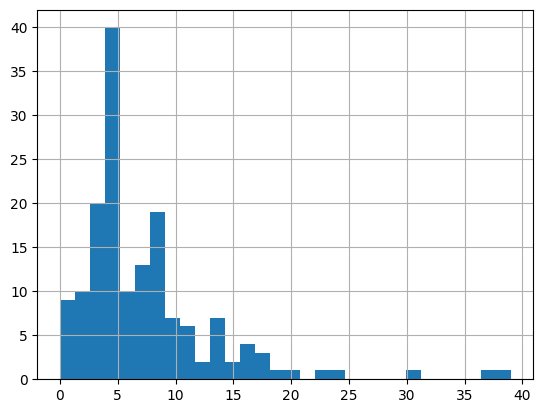

In [73]:
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in train_text]

pd.Series(seq_len).hist(bins = 30)

In [29]:
train_encodings = tokenizer(list(X_train), truncation=True, padding=True, max_length=512)
test_encodings = tokenizer(list(X_test), truncation=True, padding=True, max_length=512)

# Convert data to numpy arrays
X_train_input_ids = np.array(train_encodings['input_ids'])
X_train_attention_masks = np.array(train_encodings['attention_mask'])

X_test_input_ids = np.array(test_encodings['input_ids'])
X_test_attention_masks = np.array(test_encodings['attention_mask'])

# Convert input to PyTorch tensors
X_train_input_ids = torch.tensor(train_encodings['input_ids'])
X_train_attention_masks = torch.tensor(train_encodings['attention_mask'])
X_test_input_ids = torch.tensor(test_encodings['input_ids'])
X_test_attention_masks = torch.tensor(test_encodings['attention_mask'])

# Get word embeddings
train_embeddings = model(X_train_input_ids, X_train_attention_masks)[0][:, 0, :]
test_embeddings = model(X_test_input_ids, X_test_attention_masks)[0][:, 0, :]

In [74]:
log_cv_score = cross_val_score(log_reg, X_train_tf, y_train, cv=20, scoring='f1_macro', n_jobs=-1)
mean_log_cv = np.mean(log_cv_score)
mean_log_cv


0.5476177127143964

In [75]:
lin_svc = LinearSVC()

In [78]:
lin_svc_cv_score = cross_val_score(lin_svc,X_train_tf,y_train,cv=10,scoring='f1_macro',n_jobs=-1)
mean_lin_svc_cv = np.mean(lin_svc_cv_score)
mean_lin_svc_cv

0.6281864749085628

In [80]:
adab = AdaBoostClassifier()

In [82]:
adab_cv_score = cross_val_score(adab,X_train_tf,y_train,cv=10,scoring='f1_macro',n_jobs=-1)
mean_adab_cv = np.mean(adab_cv_score)
mean_adab_cv

0.5439758097314462

In [84]:
svc1 = LinearSVC()
param_grid = {'C':[0.0001,0.001,0.01,0.1,1,10],
'loss':['hinge','squared_hinge'],
'fit_intercept':[True,False]}
grid_search = GridSearchCV(svc1,param_grid,cv=5,scoring='f1_macro',n_jobs=-1,verbose=0,return_train_score=True)
grid_search.fit(X_train_tf,y_train)


C:\Users\BIGNETWORK\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


GridSearchCV(cv=5, estimator=LinearSVC(), n_jobs=-1,
             param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 1, 10],
                         'fit_intercept': [True, False],
                         'loss': ['hinge', 'squared_hinge']},
             return_train_score=True, scoring='f1_macro')

In [85]:
grid_search.best_estimator_

LinearSVC(C=10, loss='hinge')

In [86]:
grid_search.best_score_

0.622473330995484

* BERT

In [135]:
from tqdm.auto import tqdm
from transformers import BertTokenizer,TFBertModel

In [136]:
tokenizerbrt = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

In [137]:
token = tokenizerbrt.encode_plus(
    df['comments_clean'].iloc[0], 
    max_length=256, 
    truncation=True, 
    padding='max_length', 
    add_special_tokens=True,
    return_tensors='tf'
)

X_input_ids = np.zeros((len(df), 256))
X_attn_masks = np.zeros((len(df), 256))

In [730]:
def generate_training_data(df, ids, masks, tokenizer):
    for i, text in tqdm(enumerate(df['comments_clean'])):
        tokenized_text = tokenizer.encode_plus(
            text,
            max_length=256, 
            truncation=True, 
            padding='max_length', 
            add_special_tokens=True,
            return_tensors='tf'
        )
        ids[i, :] = tokenized_text.input_ids
        masks[i, :] = tokenized_text.attention_mask
    return ids, masks

X_input_ids, X_attn_masks = generate_training_data(df, X_input_ids, X_attn_masks, tokenizer)

15046it [00:11, 1339.22it/s]


In [731]:
labels = np.zeros((len(df), 3))
labels[np.arange(len(df)), df['class'].values] = 1 # one-hot encoded target tensor
labels

array([[1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       ...,
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.]])

In [732]:
# creating a data pipeline using tensorflow dataset utility, creates batches of data for easy loading...
dataset = tf.data.Dataset.from_tensor_slices((X_input_ids, X_attn_masks, labels))
dataset.take(1) # one sample data

def classDatasetMapFunction(input_ids, attn_masks, labels):
    return {
        'input_ids': input_ids,
        'attention_mask': attn_masks
    }, labels

In [733]:
dataset = dataset.map(classDatasetMapFunction) # converting to required format for tensorflow dataset
dataset.take(1)

<_TakeDataset element_spec=({'input_ids': TensorSpec(shape=(256,), dtype=tf.float64, name=None), 'attention_mask': TensorSpec(shape=(256,), dtype=tf.float64, name=None)}, TensorSpec(shape=(3,), dtype=tf.float64, name=None))>

In [734]:
dataset = dataset.shuffle(10000).batch(16, drop_remainder=True) # batch size, drop any left out tensor
p = 0.8
train_size = int((len(df)//16)*p) # for each 16 batch of data we will have len(df)//16 samples, take 80% of that for train

train_dataset = dataset.take(train_size)
val_dataset = dataset.skip(train_size)

In [736]:
# Load pre-trained BERT model
model = TFBertModel.from_pretrained('bert-base-multilingual-cased')

Some layers from the model checkpoint at bert-base-multilingual-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-multilingual-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [737]:
model.save_pretrained("bert_multi_classification")

In [738]:
bert_model = TFBertModel.from_pretrained("bert_multi_classification")

All model checkpoint layers were used when initializing TFBertModel.

All the layers of TFBertModel were initialized from the model checkpoint at bert_multi_classification.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [740]:
# Define input layers
input_ids = tf.keras.layers.Input(shape=(256,), name='input_ids', dtype='int32')
attn_masks = tf.keras.layers.Input(shape=(256,), name='attention_mask', dtype='int32')

# Get BERT embeddings
bert_outputs = bert_model(input_ids, attention_mask=attn_masks)
bert_embds = bert_outputs[1]  # pooled output layer (2D)

# Intermediate and output layers
intermediate_layer = tf.keras.layers.Dense(512, activation='relu', name='intermediate_layer')(bert_embds)
output_layer = tf.keras.layers.Dense(3, activation='softmax', name='output_layer')(intermediate_layer)

# Define the model
classification_model = tf.keras.Model(inputs=[input_ids, attn_masks], outputs=output_layer)
classification_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 256)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 256)]        0           []                               
                                                                                                  
 tf_bert_model_1 (TFBertModel)  TFBaseModelOutputWi  177853440   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 256,                                         

In [ ]:
optim = tf.keras.optimizers.Adam(learning_rate=5e-5)
loss_func = tf.keras.losses.CategoricalCrossentropy()
acc = tf.keras.metrics.CategoricalAccuracy('accuracy')

classification_model.compile(optimizer=optim, loss=loss_func, metrics=[acc])
hist = classification_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10
)

In [127]:
from tensorflow import keras

In [130]:
from transformers import TFBertModel
# Define the custom object scope
custom_objects = {'TFBertModel': TFBertModel}  # Replace TFBertModel with the actual custom layer class

# Load the model architecture from the saved file
hate_classification_model = keras.models.load_model('hate_classification_model/model.h5', custom_objects=custom_objects)

# Load the model weights into the architecture
hate_classification_model.load_weights('hate_classification_model/model_weights.h5')


In [141]:
def prepare_data(input_text, tokenizer):
    token = tokenizerbrt.encode_plus(
        input_text,
        max_length=256, 
        truncation=True, 
        padding='max_length', 
        add_special_tokens=True,
        return_tensors='tf'
    )
    return {
        'input_ids': tf.cast(token.input_ids, tf.float64),
        'attention_mask': tf.cast(token.attention_mask, tf.float64)
    }
def make_prediction(model, processed_data, classes=['Neutral', 'Hateful', 'Offensive']):
    probs = model.predict(processed_data)[0]
    class_probabilities = {cls: prob for cls, prob in zip(classes, probs)}
    return class_probabilities

In [230]:
input_text = input('Enter your comment here: ')
processed_data = prepare_data(input_text, tokenizer)
result = make_prediction(hate_classification_model, processed_data=processed_data)
print("Predicted probabilities:")
for cls, prob in result.items():
    print(f"{cls}: {prob}")

1/1 [==============================] - 1s 751ms/step
Predicted probabilities:
Neutral: 0.9961469173431396
Hateful: 0.003246576990932226
Offensive: 0.0006064394838176668
